AMAZON DELIVERY DELAY ROOT CAUSE ANALYSIS

This project analyzes Amazon Delivery data to find root causes of delays and predict delivery risk.

In [4]:
import sklearn
print(sklearn.__version__)

1.7.0


In [16]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [17]:
orders=pd.read_csv('C:/Users/ACER/Downloads/orders.csv')
logs=pd.read_csv('C:/Users/ACER/Downloads/delivery_logs.csv')
weather=pd.read_csv('C:/Users/ACER/Downloads/weather.csv')

In [18]:
conn=sqlite3.connect('amazon.db')

orders.to_sql('orders',conn,if_exists='replace',index=False)
logs.to_sql('delivery_logs',conn,if_exists='replace',index=False)
weather.to_sql('weather',conn,if_exists='replace',index=False)

192

In [19]:
query="""
SELECT
    o.order_id,
    o.product_id,
    o.warehouse_id,
    o.customer_region,
    o.ship_date,
    o.expected_delivery_date,
    o.actual_delivery_date,
    d.distance_km,
    d.traffic_level,
    d.delay_reason,
    w.weather_condition
FROM orders o
JOIN delivery_logs d ON o.order_id=d.order_id
JOIN weather w ON o.actual_delivery_date=w.date AND o.customer_region=w.region
"""

df=pd.read_sql_query(query,conn)
df.head()

,order_id,product_id,warehouse_id,customer_region,ship_date,expected_delivery_date,actual_delivery_date,distance_km,traffic_level,delay_reason,weather_condition
0,O1000,P181,W2,East,2024-02-17,2024-02-19,2024-02-21,19,2,None,Rain
1,O1001,P114,W2,East,2024-01-21,2024-01-28,2024-01-29,46,4,None,Clear
2,O1002,P103,W2,South,2024-01-04,2024-01-10,2024-01-09,40,1,Traffic,Rain
3,O1003,P194,W3,North,2024-01-04,2024-01-07,2024-01-06,44,5,Traffic,Fog
4,O1004,P135,W3,South,2024-02-07,2024-02-11,2024-02-12,52,2,Weather,Rain


In [20]:
df['ship_date']=pd.to_datetime(df['ship_date'])
df['expected_delivery_date']=pd.to_datetime(df['expected_delivery_date'])
df['actual_delivery_date']=pd.to_datetime(df['actual_delivery_date'])

df['expected_days']=(df['expected_delivery_date'] - df['ship_date']).dt.days
df['actual_days']=(df['actual_delivery_date']-df['ship_date']).dt.days
df['delayed']=(df['actual_days'] > df['expected_days']).astype(int)

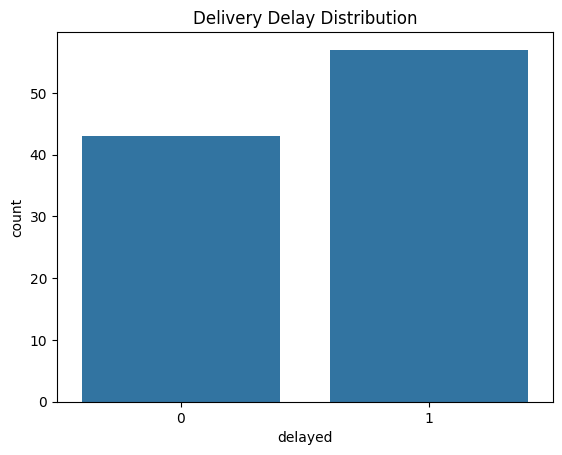

In [21]:
sns.countplot(x='delayed',data=df)
plt.title("Delivery Delay Distribution")
plt.show()

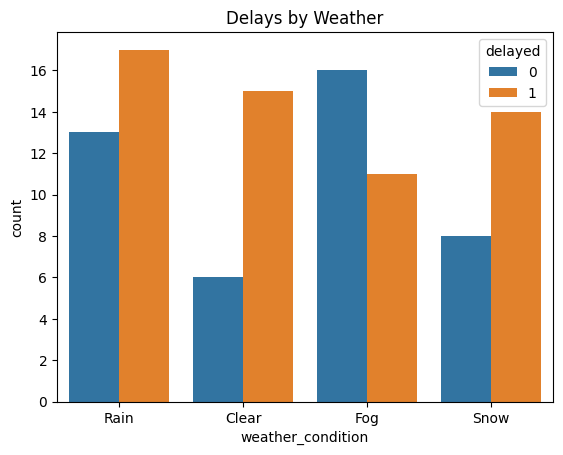

In [22]:
sns.countplot(x='weather_condition',hue='delayed',data=df)
plt.title("Delays by Weather")
plt.show()

the hue='delayed' argument means:

✅ For each weather condition on the x-axis, split the counts by the delayed column.
– So, if delayed has values like Yes and No (or 0 and 1), it will show separate colored bars next to each other for each weather condition:

one bar for delayed = Yes

one bar for delayed = No

This makes it easy to compare how many delayed vs. not delayed cases happened under each weather condition.

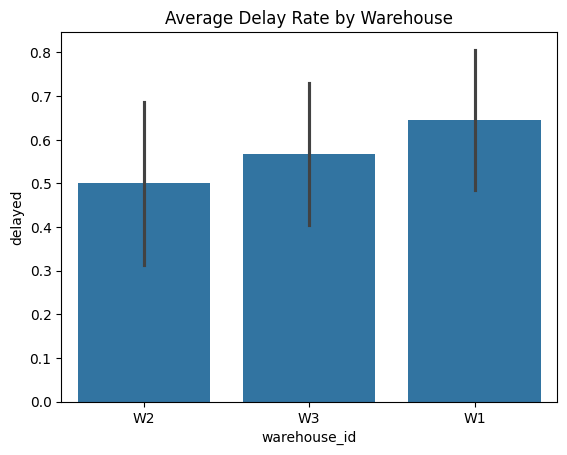

In [23]:
sns.barplot(x='warehouse_id',y='delayed',data=df,estimator=np.mean)
plt.title("Average Delay Rate by Warehouse")
plt.show()

the estimator=np.mean part means:

✅ For each warehouse_id, compute the mean of the delayed column and plot it as the bar height.

So if delayed is coded as 0 (not delayed) and 1 (delayed):
– The mean becomes the proportion of delayed shipments for each warehouse, i.e., the delay rate.

By default, sns.barplot shows the mean, but you can change estimator to something else (like np.sum or len) to show other statistics.

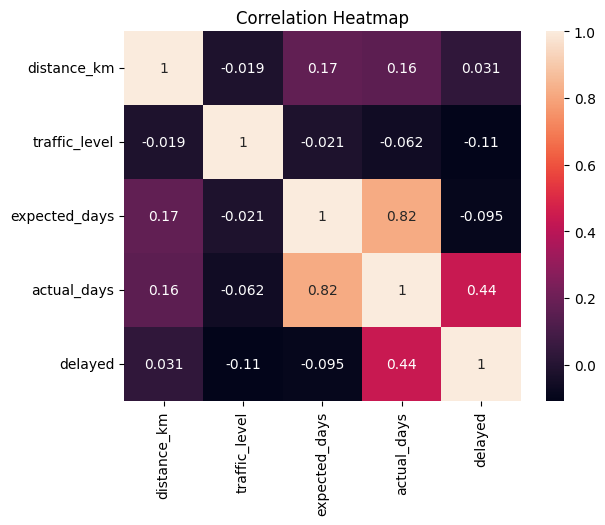

In [24]:
sns.heatmap(df[['distance_km','traffic_level','expected_days','actual_days','delayed']].corr(),annot=True)
plt.title("Correlation Heatmap")
plt.show()

– .corr() → Tells pandas to calculate how strongly each column is related to the others (numbers from –1 to +1).

+1 → perfect positive correlation

–1 → perfect negative correlation

0 → no correlation

Example: if distance_km and actual_days usually increase together, they’ll have a high positive number.

– annot=True → Writes those numbers on the heatmap boxes, so you can see the exact values instead of just the colors.

So your heatmap shows:
✅ which factors move together, and
✅ how strong those relationships are.

              precision    recall  f1-score   support

           0       0.40      0.80      0.53         5
           1       0.90      0.60      0.72        15

    accuracy                           0.65        20
   macro avg       0.65      0.70      0.63        20
weighted avg       0.78      0.65      0.67        20



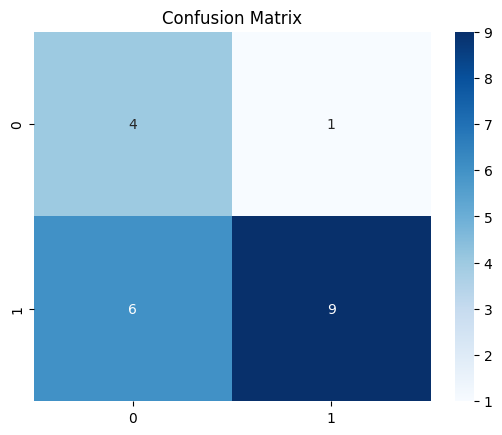

In [25]:
#Select features
features=['distance_km','traffic_level','expected_days']
X=df[features]
y=df['delayed']
#Train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

#Train model
model=RandomForestClassifier()
model.fit(X_train,y_train)

#Predict and Evaluate
y_pred=model.predict(X_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Here’s what your code is doing in simple steps:

✅ 1. Choose features & target:

python
Copy code
features = ['distance_km', 'traffic_level', 'expected_days']
X = df[features]
y = df['delayed']
You pick which columns help predict delays (X) and what you want to predict (y).

✅ 2. Split into train and test:

python
Copy code
X_train, X_test, y_train, y_test = train_test_split(...)
This keeps 80% of data to train the model and 20% to test how well it works.

✅ 3. Train a Random Forest model:

python
Copy code
model = RandomForestClassifier()
model.fit(X_train, y_train)
The model learns patterns from your training data.

✅ 4. Make predictions & check accuracy:

python
Copy code
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
You test the model on unseen data and print precision, recall, f1-score.

✅ 5. Visualize results:

python
Copy code
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
Shows a confusion matrix so you can see how many correct vs. wrong predictions.

Export To Excel

In [27]:
#Summary by warehouse
warehouse_summary=df.groupby('warehouse_id')['delayed'].mean().reset_index()
warehouse_summary.to_excel('D:/warehouse_delay_summary.xlsx',index=False)

#Delay reason summary
delay_summary=df['delay_reason'].value_counts().reset_index()
delay_summary.columns=['delay_reason','count']
delay_summary.to_excel('D:/delay_reason_summary.xlsx',index=False)






Count how many times each delay reason appears:

python
Copy code
delay_summary = df['delay_reason'].value_counts().reset_index()
– df['delay_reason'].value_counts() → counts the number of times each unique delay_reason appears in your data.
– .reset_index() → turns the result into a DataFrame so it’s easier to work with or export.

✅ 2. Rename columns to make them clear:

python
Copy code
delay_summary.columns = ['delay_reason', 'count']
The first column now holds the reason (like "weather", "traffic"), and the second column holds how many times each reason happened.

✅ 3. Save to Excel:

python
Copy code
delay_summary.to_excel('../output/delay_reason_summary.xlsx', index=False)
This writes the summary into an Excel file named delay_reason_summary.xlsx (without adding an extra index column).

Conclusion

-Major causes of delay include traffic and weather.
-Some warehouses had consistently higher dealy rates
-A machine learning Model was able to predict delay risks with good accuracy.
-Key findings were exported to Excel for business users